<a href="https://colab.research.google.com/github/AJ-21cm/AJ-21cm/blob/main/Degree__Biased_CTRW_Real_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pa

In [ ]:
pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 25.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.1 which is incompatible.


In [ ]:
import math as m
#from math import comb
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
#import osmnx as ox
import pickle
from collections import OrderedDict

In [ ]:
import numpy as np
import math as m
import pickle
from collections import OrderedDict
import pandas as pd
import sys

def storeData(db,file_name):
    # Its important to use binary mode
    dbfile = open(file_name, 'wb')
    # source, destination
    pickle.dump(db, dbfile)
    dbfile.close()
def loadData(file_name):
    # for reading also binary mode is important
    dbfile = open(file_name, 'rb')
    db = pickle.load(dbfile)
    dbfile.close()
    return db

def nodes_with_same_Degree(node_Degree_dict):
  Degrees=list(set(node_Degree_dict.values()))
  nodes_degree=[]
  for i in Degrees:
    x=[]
    for j,k in node_Degree_dict.items():
      if i==k:
         x.append(j)
    nodes_degree.append([i,x])
  return nodes_degree

def Walk_each_node(nodes,Time_S):
  wal_on_each_node={}
  for a in range(0,nodes):
    time_seq=[]
    for i in Time_S:
      #print(i)
      for j in i:
        #print(j)
        if j[1]==a:
            time_seq.append(j[0])
      wal_on_each_node[a]=time_seq
  return wal_on_each_node

#-------------------------------------------------------------------------
def Time_series_each_node(nodes,wal_on_each_node):
  dic_timeseries_each_node={}
  for j in range(nodes):
    lis=np.array(wal_on_each_node[j])
    set_=wal_on_each_node[j]
    dictt_={}
    for i in set_:
      c=np.count_nonzero(lis == i)
      dictt_[i]=c
    dic_timeseries_each_node[j]=OrderedDict(sorted(dictt_.items()))
    #print(dic_timeseries_each_node)
  return dic_timeseries_each_node
#------------------------------------------------------------------------------
def comp_mini_ended_valueforTimeSeries(nodes,time_series_each_node):
  ss=[]
  for i in range(nodes):
    t=time_series_each_node[i]
    l=list(t.keys())
    ss.append(l[-1])
  return min(ss)
#---------------------------------------------------------------------------------
def Time_series_CTRW_windowtime(win_t,time_lim,time_series_each_node,Nodes):
  Time_series_each_node={}
  for node in range(Nodes):
    node_time=[[j,time_series_each_node[node][j]] for j in time_series_each_node[node]]
    array=np.array(node_time)
    length=len(node_time)
    new_array=[]
    x,y=0,win_t
    i=0
    if array[0][0]==0:
      new_array.append([0,array[i][1]])
      i+=1
    else:
      new_array.append([0,0])
    while True:
      sum=0
      while array[i][0]>x and array[i][0]<=y:
            sum+=array[i][1]
            i+=1
            if i==length:
               print(i,length)
               break
      new_array.append([y,sum])
      if y>=time_lim:
        break
      x=y
      y=y+win_t
    Time_series_each_node[node]=new_array
  return Time_series_each_node
#-----------------------------------------------------------------
def walkers_statistic_nodewise(Ctime_series_dict,nodes):
  dic_mean_walkers={}
  dic_std_walkers={}
  for a in range(nodes):
    new_array=np.array(Ctime_series_dict[a])
    dic_mean_walkers[a]=np.mean(np.array([i[1] for i in new_array ]))
    dic_std_walkers[a]=np.std(np.array([i[1] for i in new_array]))
  return dic_mean_walkers,dic_std_walkers

#----------------------------------------------------------------------------------------------------------------
def walkers_statistic_degreewise(nodes_with_same_degrees,mean_walkers_dic ,std_walkers_dic):
  dic_meanW_PER_node_degreewise={}
  dic_stdW_PER_node_degreewise={}
  for nodes in nodes_with_same_degrees:
    deg=nodes[0]
    sameDeg_nodes=nodes[1]
    dic_meanW_PER_node_degreewise[deg]=[mean_walkers_dic[n] for n in sameDeg_nodes ]
    dic_stdW_PER_node_degreewise[deg]=[std_walkers_dic[n] for n in sameDeg_nodes]
  Avg_walk_degreewise=np.array([[i,np.mean(np.array(dic_meanW_PER_node_degreewise[i]))] for i in dic_meanW_PER_node_degreewise])
  Std_walk_degreewise=np.array([[j,np.mean(np.array(dic_stdW_PER_node_degreewise[j]))] for j in dic_stdW_PER_node_degreewise])
  return Avg_walk_degreewise,Std_walk_degreewise


#Extreme event probability calculation

def EE_Prob(Nodes,nodes_with_same_degrees,Scaling_factor,CTimeS_each_node,mean_walkers_dic,std_walkers_dic):
  Extreme_event_nodewise={}
  timeS_size=float(np.size(np.array(CTimeS_each_node[0])))
  thresh_hold_Arr={}
  for node in range(Nodes):
    node_TS=np.array(CTimeS_each_node[node])
    walkers_array=node_TS[::,1]
    threshold=mean_walkers_dic[node]+Scaling_factor*std_walkers_dic[node]
    thresh_hold_Arr[node]=threshold
    Extreme_event_nodewise[node]=np.count_nonzero((np.where( walkers_array>threshold, 1,0)))/timeS_size
  Extreme_event_prob_degreewise={}
  for i in nodes_with_same_degrees:
     Extreme_event_prob_degreewise[i[0]]=np.mean(np.array([Extreme_event_nodewise[j] for j in i[1]]))
  return thresh_hold_Arr,Extreme_event_nodewise,Extreme_event_prob_degreewise


def EE_recurr_Time(Nodes,CTimeS_each_node,threshold_array):
  nodewise_timeDiff={}
  for node in range(Nodes):
    node_TS=np.array(CTimeS_each_node[node])
    walkers_array=node_TS[::,1]
    only_time=node_TS[::,0]
    threshold=threshold_array[node]
    Extreme_event_points=np.where( walkers_array>threshold,1,0)
    I_val=Extreme_event_points[0]
    Time_values=np.multiply(Extreme_event_points,only_time)
    exact_time_values=Time_values[np.where(Time_values!=0)]
    if I_val==1:
      exact_time_values=np.insert(exact_time_values,0,0)
    arr_size=np.size(exact_time_values)
    if arr_size>1:
      Time_diff=[]
      for i in range(len(exact_time_values)-1):
          Time_diff.append(exact_time_values[i+1]-exact_time_values[i])
      nodewise_timeDiff[node]=np.array(Time_diff)
    elif arr_size==1:
      nodewise_timeDiff[node]=exact_time_values
    else:
        nodewise_timeDiff[node]=np.array([0])
  return nodewise_timeDiff

def Avg_recurrTime_Node_Degreewise(nodes,nodes_same_degree,RecurrenArray_nodewise):
  dic_average_RecurrenceTime_nodewise={}
  for i in range(nodes):
    dic_average_RecurrenceTime_nodewise[i]=np.mean(np.array([RecurrenArray_nodewise[i]]))
  dic_average_RecurrenceTime_degreewise={}
  for j in nodes_same_degree:
      dic_average_RecurrenceTime_degreewise[j[0]]=np.mean(np.array([dic_average_RecurrenceTime_nodewise[k] for k in j[1]]))
  return  dic_average_RecurrenceTime_nodewise,dic_average_RecurrenceTime_degreewise

def Abs_diff_mag_EE(nodes,CTimeS_each_node,threshold_array):
  nodewise_EE_abs_diff={}
  for node in range(nodes):
    node_TS=np.array(CTimeS_each_node[node])
    walkers_array=node_TS[::,1]
    only_time=node_TS[::,0]
    threshold=threshold_array[node]
    Extreme_event_values=np.where( walkers_array>threshold,walkers_array,0)
    Exact_EE_values=Extreme_event_values[np.where(Extreme_event_values!=0)]
    arr_size=np.size(Exact_EE_values)
    if arr_size>1:
      EE_abs_diff=[]
      for i in range(len(Exact_EE_values)-1):
            EE_abs_diff.append(abs(Exact_EE_values[i+1]-Exact_EE_values[i]))
      nodewise_EE_abs_diff[node]=np.array(EE_abs_diff)
    elif arr_size==1:
      nodewise_EE_abs_diff[node]=Exact_EE_values
    else:
      nodewise_EE_abs_diff[node]=np.array([0])
  return nodewise_EE_abs_diff

def Avg_Abs_diff_mag_EE_Node_Degreewise(nodes,nodes_degrees,nodewise_EE_abs_diff):
  dic_average_Absolute_diff_mag_EE_nodewise={}
  for i in range(nodes):
    dic_average_Absolute_diff_mag_EE_nodewise[i]=np.mean(np.array([nodewise_EE_abs_diff[i]]))
  dic_average_Absolute_diff_mag_EE_degreewise={}
  for j in nodes_degrees:
      dic_average_Absolute_diff_mag_EE_degreewise[j[0]]=np.mean(np.array([dic_average_Absolute_diff_mag_EE_nodewise[k] for k in j[1]]))
  return  dic_average_Absolute_diff_mag_EE_nodewise,dic_average_Absolute_diff_mag_EE_degreewise

city_name="NewYork_"


file_name="/content/drive/MyDrive/MS_thesis_work/adjacency_list_"+city_name
adjacency_list=loadData(file_name)
node_Degree_dict={i:len(adjacency_list[i]) for i in adjacency_list}
nodes_same_deg=nodes_with_same_Degree(node_Degree_dict)
nodes=len(adjacency_list.keys())
Degrees=list(set(node_Degree_dict.values()))


alpha_arr=np.array([-2,-1,0,1,2],dtype=int)
alpha_n=["m_2","m_1","0","1","2"]
window_time=np.array([5,10,15,20,25,30],dtype=int)
max_TS=np.array([9900,9900,9900,9900,9900,9900],dtype=int)
for win,max_len in zip(window_time,max_TS):
  df_all=pd.DataFrame()
  df_deg=pd.DataFrame()
  df_deg['Deg']=np.array(Degrees)
  for al_n in alpha_n:
    filename="/content/drive/MyDrive/MS_thesis_work/DB_CTRW/DB_CTRW_"+al_n+"_"+city_name+"5000_walkers_11000s"
    Time_S=loadData(filename)
    TS_CTRW_node_dict=Time_series_CTRW_windowtime(win,max_len,Time_S,nodes)
    #Computing average and standard deviation of walkers for each node
    dic_mean_walkers ,dic_std_walkers=walkers_statistic_nodewise(TS_CTRW_node_dict,nodes)
    df_all["mw_"+al_n] =np.array([dic_mean_walkers[i] for i in dic_mean_walkers])
    df_all["sw_"+al_n] =np.array([dic_std_walkers[i] for i in dic_std_walkers])
    #Computing average and standard deviation of walkers degreewise
    Avg_walk_deg,Std_walk_deg=walkers_statistic_degreewise(nodes_same_deg,dic_mean_walkers,dic_std_walkers)
    df_deg["mw_"+al_n]=Avg_walk_deg[::,1]
    df_deg["sw_"+al_n]=Std_walk_deg[::,1]
    #Computing EE values for each node
    Scaling_factor=2
    threshold_dict,EEP_nodewise,EEP_degreewise=EE_Prob(nodes,nodes_same_deg,Scaling_factor,TS_CTRW_node_dict,dic_mean_walkers,dic_std_walkers)
    #Computing recurrence time interval
    reccT_node_dict=EE_recurr_Time(nodes,TS_CTRW_node_dict,threshold_dict)
    avg_recurrT_node,avg_recurrT_deg=Avg_recurrTime_Node_Degreewise(nodes,nodes_same_deg,reccT_node_dict)
    #Computing absolute difference of magnitude of EE
    EE_abs_diff_node_dict=Abs_diff_mag_EE(nodes,TS_CTRW_node_dict,threshold_dict)
    AvgEE_abs_diff_node,AvgEE_abs_diff_deg=Avg_Abs_diff_mag_EE_Node_Degreewise(nodes,nodes_same_deg,EE_abs_diff_node_dict)
    df_deg["EE_"+al_n]=np.array([EEP_degreewise[i] for i in EEP_degreewise])
    df_all["th_val_"+al_n]=np.array([threshold_dict[i] for i in threshold_dict])
    df_all["EE_"+al_n]=np.array([EEP_nodewise[i] for i in EEP_nodewise])
    df_all["m_recT_"+al_n]=np.array([avg_recurrT_node[i] for i in avg_recurrT_node])
    df_deg["m_recT_"+al_n]=np.array([avg_recurrT_deg[i] for i in avg_recurrT_deg])
    df_all["m_EEabsDiff_"+al_n]=np.array([AvgEE_abs_diff_node[i] for i in avg_recurrT_node])
    df_deg["m_EEabsDiff_"+al_n]=np.array([AvgEE_abs_diff_deg[i] for i in avg_recurrT_deg])
  df_all.to_csv(city_name+"DB_stat_Nodewise_winT_"+str(win)+"_scaleP_"+str(Scaling_factor))
  df_deg.to_csv(city_name+"DB_stat_Degwise_winT_"+str(win)+"_scaleP_"+str(Scaling_factor))

FileNotFoundError: ignored

In [ ]:
np.nan

nan

In [ ]:
Extreme_event_values=np.array([0,0,0])
Exact_EE_values=Extreme_event_values[np.where(Extreme_event_values!=0)]
Exact_EE_values

array([], dtype=int64)

In [ ]:
"DB_CTRW_"+al_n+"_"+city_name+"5000_walkers_11000s"

'DB_CTRW_2_NewYork_5000_walkers_11000s'

In [ ]:
df_deg

,Deg,mw_m_2_30,sw_m_2_30,EE_m_2_30,m_recT_m_2_30,m_EEabsDiff_m_2_30,mw_m_1_30,sw_m_1_30,EE_m_1_30,m_recT_m_1_30,...,mw_1_30,sw_1_30,EE_1_30,m_recT_1_30,m_EEabsDiff_1_30,mw_2_30,sw_2_30,EE_2_30,m_recT_2_30,m_EEabsDiff_2_30
0,1,54.475693,13.585794,0.010711,1029.759740,20.458189,15.748146,5.803862,0.015380,821.720772,...,1.162043,1.195851,0.026229,566.792291,0.769531,0.310080,0.604582,0.024993,862.449775,0.500156
1,2,28.583082,7.508615,0.014194,967.271147,5.891529,15.497919,5.004527,0.015419,848.018514,...,4.567064,2.339513,0.017671,865.681769,1.118610,2.353303,1.625486,0.018896,851.179230,0.860849
2,3,16.286422,4.956834,0.015539,878.216569,2.255154,14.858799,4.635922,0.015333,917.883856,...,10.630379,3.737325,0.016371,853.853002,1.719421,8.579273,3.292348,0.016550,861.721822,1.607902
3,4,11.116555,3.867232,0.016694,852.155725,1.833697,14.193073,4.340225,0.015518,929.643663,...,19.739844,5.184167,0.014579,929.651828,2.188828,21.675650,5.496822,0.014416,942.978405,2.354447
4,5,9.417468,3.398894,0.015243,863.290024,1.615093,14.800467,4.352809,0.015106,902.361093,...,29.102032,6.610477,0.014213,926.356568,2.736563,38.777396,7.879151,0.012634,1009.602557,3.365391
5,6,9.151057,3.371978,0.015106,890.583333,1.502778,15.516616,4.480074,0.017372,810.857143,...,41.063444,7.876253,0.010196,957.392857,2.651190,60.222810,10.359197,0.011329,600.625000,4.135417


#Defining function for plotting work

In [ ]:
def scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=5,opacity=0.6,marker="o"):
  plt.scatter(xarr,yarr,s=dotsize, c=None, marker=None, cmap=None, norm=None,
  vmin=None, vmax=None, alpha=opacity, linewidths=None, edgecolors=None, plotnonfinite=False, data=None)
  #plt.plot(xarr,yarr,label=labels,ls=":")
  plt.grid()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()
def Box_Plot(xarr,xlabel,ylabel,title,label):
  plt.title(title)
  plt.boxplot(xarr,showmeans=True,  labels=label,notch=None, sym=None, vert=None, whis=None, positions=None, widths=None)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()
def HistoGram(array,bins,normalized,width,xlabel,ylabel,alingm,title,fsize):
  fig=plt.figure(figsize=fsize)
  plt.hist(array, bins=bins, range=None, density=normalized, weights=None, cumulative=False,
  bottom=None, histtype='bar', align=alingm, orientation='vertical', rwidth=width,
  log=False, color=None, label=None, stacked=False)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.grid()
def XY_plotting(x,y,xlabel,ylabel,title,linestyle,linewidth,color):
  plt.plot(x,y,ls=linestyle,lw=linewidth,c=color)
  plt.grid()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
def plotting_walker_time_Series(degree,TimeS_dict,node):
  #degre=G.degree[a]
  node_time=TimeS_dict[node]
  l=np.array(node_time)
  #print(l.shape)
  plt.ylim(0,np.max(l[::,1])+5)
  plt.scatter(l[::,0],l[::,1],s=3,c=None, marker=None, cmap=None,
              norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=None, plotnonfinite=False, data=None)
  plt.xlabel("Time(s)")
  plt.ylabel("Number of Walkers")
  plt.title("Variation of Number of walkers with continous\n time on a node of degree "+str(degree))
  #print("total numbers of walkers % passes in time %"%(sum(l[::,0]),max(l[::,1])))
  #plt.yticks([i for i in range(m.ceil(max(l[::,1])))])
  #print(l)
  plt.show()
  plt.title('Box plot')
  plt.boxplot(l[::,1],showmeans=True,  labels=None,notch=None, sym=None, vert=None, whis=None, positions=None, widths=None)
  plt.ylabel("Number of walkers")
  plt.grid()
  plt.show()

#Defining function for curve fitting

In [ ]:
def objective(x, a, b,c):
	return (a * x**b) + c
def curve_fitting(xx,yy):
  x=xx
  y=yy
  # curve fit
  popt, _ = curve_fit(objective, x, y)
  # summarize the parameter values
  a, b, c= popt
  # plot input vs output
  plt.scatter(x, y)
  # define a sequence of inputs between the smallest and largest known inputs
  #x_line = np.arange(min(x), max(x), 1)
  # calculate the output for the range
  #a,b,c=np.round(a),np.round(b),np.round(c)
  y_line = objective(x, a, b,c)
  print("scaling=",a,"exponent=",b,"shifting=",c)
  # create a line plot for the mapping function
  label=r'$ax^b +c$'+'a= '+str(a)+'b='+str(b)+'c='+str(c)
  plt.plot(x, y_line, '--', color='red')
  plt.show()

##Curve fitting using sklearn library

In [ ]:
def LinearR_sklearn(xarr,yarr):
  regr = LinearRegression()
  x=xarr.reshape(-1, 1)
  y=yarr.reshape(-1,1)
  regr.fit(x, y)
  y_pred = regr.predict(x)
  slope=np.round(regr.coef_[0,0],1)
  intercepts=np.round(regr.intercept_[0],1)
  #R_2=r2(y,y_pred)
  RMSE=m.sqrt(mse(y,y_pred))
  return y_pred,slope,intercepts#,R_2,RMSE

#Defining function for writing and reading data from a binary file

In [ ]:
def storeData(db,file_name):
    # Its important to use binary mode
    dbfile = open(file_name, 'wb')
    # source, destination
    pickle.dump(db, dbfile)
    dbfile.close()
def loadData(file_name):
    # for reading also binary mode is important
    dbfile = open(file_name, 'rb')
    db = pickle.load(dbfile)
    dbfile.close()
    return db

#Functions defined for categorizing nodes of same degree

In [ ]:
def plotting_degree_distribution(nodes_degrees):
  nodes_degreewiseFrequency=[]
  for i in nodes_degrees:
   nodes_degreewiseFrequency.append([i[0],len(i[1])])
  nodes_degreewiseFrequency=np.array(nodes_degreewiseFrequency)
  fig=plt.figure(figsize=(10,5))
  plt.bar(nodes_degreewiseFrequency[::,0],nodes_degreewiseFrequency[::,1])
  plt.xlabel("Degrees")
  plt.ylabel("Frequency")
  plt.title("Degree Distribution")
  #plt.xticks([i for i in range(5,130,5)])
def nodes_with_same_Degree(node_Degree_dict):
  Degrees=list(set(node_Degree_dict.values()))
  nodes_degree=[]
  for i in Degrees:
    x=[]
    for j,k in node_Degree_dict.items():
      if i==k:
         x.append(j)
    nodes_degree.append([i,x])
  return nodes_degree
def nodes_with_degree_osmnxdata(G):
  nodeAdegree=[]
  list_degree=G.degree()
  #degre=m.ceil(G1.degree[a]/2)
  degrees=set([m.ceil(i[1]/2) for i in list_degree])
  max_deg=max(list(degrees))
  for i in degrees:
    x=[v for v,d in G.degree() if m.ceil(d/2)==i]
    nodeAdegree.append([i,x])
  return nodeAdegree

In [ ]:
def adjacency_list_nodeDegree_osmnxG(G,nodes):
  adjacency_list={}
  G_unD=nx.to_undirected(G)
  for i in range(nodes):
     k=[]
     for j in G_unD.neighbors(i):
         if i!=j:
           k.append(j)
     adjacency_list[i]=k
  node_Degree_dict={i:len(adjacency_list[i]) for i in adjacency_list}
  return adjacency_list,node_Degree_dict
def next_pos(adjacency_list,node_Degree_dict,pos,alpha):
  neig=adjacency_list[pos]
  Deg_arr=np.array([node_Degree_dict[i] for i in neig],dtype=float)
  Deg_arr_=np.power(Deg_arr,alpha)
  prob=[j/sum(Deg_arr_) for j in Deg_arr_]
  next_pos=np.random.choice(neig,size=None, replace=True, p=prob)
  return next_pos
def CTRW_sim(nodes,length_dict,adjacency_list,node_Degree_dict,num_wal,tmax):
  Time_whole=[]
  start_end_whole=[]
  for m in range(num_wal):
    start_node=np.random.randint(low=0, high=nodes, size=1, dtype=int)[0]
    #print("walker is starting at",starting_node)
    Time=[[0,start_node]]
    start_end_data=[]
    while True:
      #print("time of walker",Time[-1][0])
      if Time[-1][0]>=tmax:
          break
      next_node=next_pos(adjacency_list,node_Degree_dict,start_node,-2)
      speed=abs(np.random.normal(loc=40, scale=5, size=None))*0.28
      if start_node<next_node:
        time=np.round((length_dict[(start_node,next_node,0)])/speed + Time[-1][0],1)
      else:
        time=np.round((length_dict[(next_node,start_node,0)])/speed + Time[-1][0],1)
      if time>=tmax:
        Time.append([time,next_node])
        start_end_data.append([start_node,next_node])
        break
      Time.append([time,next_node])
      start_node=next_node
    Time_whole.append(Time)
    start_end_whole.append(start_end_data)
    #print("start end whole information",start_end_whole)
  return Time_whole
def Walk_each_node(nodes,Time_S):
  wal_on_each_node={}
  for a in range(0,nodes):
    time_seq=[]
    for i in Time_S:
      #print(i)
      for j in i:
        #print(j)
        if j[1]==a:
            time_seq.append(j[0])
      wal_on_each_node[a]=time_seq
  return wal_on_each_node

#-------------------------------------------------------------------------
def Time_series_each_node(nodes,wal_on_each_node):
  dic_timeseries_each_node={}
  for j in range(nodes):
    lis=np.array(wal_on_each_node[j])
    set_=wal_on_each_node[j]
    dictt_={}
    for i in set_:
      c=np.count_nonzero(lis == i)
      dictt_[i]=c
    dic_timeseries_each_node[j]=OrderedDict(sorted(dictt_.items()))
    #print(dic_timeseries_each_node)
  return dic_timeseries_each_node
#------------------------------------------------------------------------------
def comp_mini_ended_valueforTimeSeries(nodes,time_series_each_node):
  ss=[]
  for i in range(nodes):
    t=time_series_each_node[i]
    l=list(t.keys())
    ss.append(l[-1])
  return min(ss)
#---------------------------------------------------------------------------------
def Time_series_CTRW_windowtime(win_t,time_lim,time_series_each_node,Nodes):
  Time_series_each_node={}
  for node in range(Nodes):
    node_time=[[j,time_series_each_node[node][j]] for j in time_series_each_node[node]]
    array=np.array(node_time)
    length=len(node_time)
    new_array=[]
    x,y=0,win_t
    i=0
    if array[0][0]==0:
      new_array.append([0,array[i][1]])
      i+=1
    else:
      new_array.append([0,0])
    while True:
      sum=0
      while array[i][0]>x and array[i][0]<=y:
            sum+=array[i][1]
            i+=1
            if i==length:
               print(i,length)
               break
      new_array.append([y,sum])
      if y>=time_lim:
        break
      x=y
      y=y+win_t
    Time_series_each_node[node]=new_array
  return Time_series_each_node
#calculation of mean numbers and std of walkers for each node
def mean_std_walkers_nodewise(time_series_each_node,nodes):
  dic_mean_walkers={}
  dic_std_walkers={}
  for a in range(nodes):
    new_array=np.array(time_series_each_node[a])
    dic_mean_walkers[a]=np.mean(np.array([i[1] for i in new_array ]))
    dic_std_walkers[a]=np.std(np.array([i[1] for i in new_array]))
  return dic_mean_walkers,dic_std_walkers
#----------------------------------------------------------------------------------------
def plotting_walker_time(degree,TimeS_dict,node):
  #degre=G.degree[a]
  node_time=TimeS_dict[node]
  l=np.array(node_time)
  #print(l.shape)
  plt.ylim(0,np.max(l[::,1])+5)
  plt.scatter(l[::,0],l[::,1],s=3,c=None, marker=None, cmap=None,
              norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=None, plotnonfinite=False, data=None)
  plt.xlabel("Time(s)")
  plt.ylabel("Number of Walkers")
  plt.title("Variation of Number of walkers with continous\n time on a node of degree "+str(degree))
  #print("total numbers of walkers % passes in time %"%(sum(l[::,0]),max(l[::,1])))
  #plt.yticks([i for i in range(m.ceil(max(l[::,1])))])
  #print(l)
  plt.show()

  plt.title('Box plot')
  plt.boxplot(l[::,1],showmeans=True,  labels=None,notch=None, sym=None, vert=None, whis=None, positions=None, widths=None)
  plt.ylabel("Number of walkers")
  plt.grid()
  plt.show()

  '''max_walker=int(max(l[::,1]))
  if max_walker<=25:ax.xaxis.ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
      alpha=max_walker//2
  if max_walker>25 and max_walker<=45:
      alpha=max_walker//3
  if max_walker>45 and max_walker<=80:
      alpha=max_walker//4
  if max_walker>80 and max_walker<=160:
      alpha=max_walker//5
  if max_walker>160:
      alpha=max_walker//6
  fig=plt.figure(figsize=(alpha,5))
  bar_plot_contructing(l[::,1])
  #bins=[i for i in range(0,max_walker+2)]
  #fig=plt.figure(figsize=(max_walker/3,5))
  #n,bin,patch=plt.hist(l[::,1], bins=bins, range=None, density=True, weights=None, cumulative=False, bottom=None, histtype='bar', align='left', orientation='vertical', rwidth=0.5, log=False, color=None, label=None, stacked=False)
  plt.title('Distribution of number of walkers')
  plt.ylabel("Frequency")
  plt.xlabel("Number of walkers")
  plt.grid()
  #plt.xticks(np.round_(bins,0))
  plt.show()

  plt.title('Violin Plot')
  plt.ylabel("Number of walkers")
  plt.grid()
  plt.violinplot(l[::,1], positions=None, vert=True, widths=0.1, showmeans=True, showextrema=True,
                 showmedians=True, points=100, bw_method=None)
  plt.show()'''
def walkers_statistic_degreewise(nodes_degrees,dic_mean_walkers ,dic_std_walkers):
  dic_meanW_PER_node_degreewise={}
  dic_stdW_PER_node_degreewise={}
  for nodes in nodes_degrees:
    deg=nodes[0]
    sameDeg_nodes=nodes[1]
    dic_meanW_PER_node_degreewise[deg]=[dic_mean_walkers[n] for n in sameDeg_nodes ]
    dic_stdW_PER_node_degreewise[deg]=[dic_std_walkers[n] for n in sameDeg_nodes]
  Average_walk_degreewise=np.array([[i,np.mean(np.array(dic_meanW_PER_node_degreewise[i]))] for i in dic_meanW_PER_node_degreewise])
  Std_walk_degreewise=np.array([[j,np.mean(np.array(dic_stdW_PER_node_degreewise[j]))] for j in dic_stdW_PER_node_degreewise])
  return Average_walk_degreewise,Std_walk_degreewise
#Extreme event probability calculation
def ExtremeEventProb(Nodes,nodes_degrees,Scaling_factor,time_series_each_node,dic_mean_walkers,dic_std_walkers):
  Extreme_event_nodewise={}
  thresh_hold_Arr={}
  for node in range(Nodes):
    #print(node)
    walkers_array=np.array(time_series_each_node[node])
    #print(walkers_array)
    threshold=dic_mean_walkers[node]+Scaling_factor*dic_std_walkers[node]
    #print(threshold)
    thresh_hold_Arr[node]=threshold
    Extreme_event_nodewise[node]=np.count_nonzero((np.where( walkers_array>threshold, 1,0)))/float(np.size(walkers_array))
  Extreme_event_prob_degreewise={}
  for i in nodes_degrees:
     Extreme_event_prob_degreewise[i[0]]=np.mean(np.array([Extreme_event_nodewise[j] for j in i[1]]))
  return thresh_hold_Arr,Extreme_event_nodewise,Extreme_event_prob_degreewise
def EE_recurrTime_each_node(Nodes,time_series_each_node,threshold_array):
  nodewise_timeDiff={}
  for node in range(Nodes):
    walkers_array=np.array(time_series_each_node[node])
    only_time=np.array([i for i in range(len(walkers_array))])
    threshold=threshold_array[node]
    Extreme_event_points=np.where( walkers_array>threshold,1,-1)
    Time_values=np.multiply(Extreme_event_points,only_time)
    exact_time_values=Time_values[np.where(Time_values>=0)]
    Time_diff=[]
    for i in range(len(exact_time_values)-1):
        Time_diff.append(exact_time_values[i+1]-exact_time_values[i])
    nodewise_timeDiff[node]=Time_diff
  return nodewise_timeDiff
def Average_recurrenceTime_Node_Degreewise(nodes,nodes_degrees,RecurrenArray_nodewise):
  dic_average_RecurrenceTime_nodewise={}
  for i in range(nodes):
    dic_average_RecurrenceTime_nodewise[i]=np.mean(np.array([RecurrenArray_nodewise[i]]))
  dic_average_RecurrenceTime_degreewise={}
  for j in nodes_degrees:
      dic_average_RecurrenceTime_degreewise[j[0]]=np.mean(np.array([dic_average_RecurrenceTime_nodewise[k] for k in j[1]]))
  return  dic_average_RecurrenceTime_nodewise,dic_average_RecurrenceTime_degreewise
def Absolute_diff_mag_EE(Nodes,time_series_each_node,threshold_array):
  nodewise_EE_abs_diff={}
  for node in range(Nodes):
    walkers_array=np.array(time_series_each_node[node])
    only_time=np.array([i for i in range(0,len(walkers_array))])
    threshold=threshold_array[node]
    Extreme_event_values=np.where( walkers_array>threshold,walkers_array,0)
    Exact_EE_values=Extreme_event_values[np.where(Extreme_event_values!=0)]
    EE_abs_diff=[]
    for i in range(len(Exact_EE_values)-1):
          EE_abs_diff.append(abs(Exact_EE_values[i+1]-Exact_EE_values[i]))
    nodewise_EE_abs_diff[node]=EE_abs_diff
  return nodewise_EE_abs_diff
def Average_Absolute_diff_mag_EE__Node_Degreewise(nodes,nodes_degrees,nodewise_EE_abs_diff):
  dic_average_Absolute_diff_mag_EE_nodewise={}
  for i in range(nodes):
    dic_average_Absolute_diff_mag_EE_nodewise[i]=np.mean(np.array([nodewise_EE_abs_diff[i]]))
  dic_average_Absolute_diff_mag_EE_degreewise={}
  for j in nodes_degrees:
      dic_average_Absolute_diff_mag_EE_degreewise[j[0]]=np.mean(np.array([dic_average_Absolute_diff_mag_EE_nodewise[k] for k in j[1]]))
  return  dic_average_Absolute_diff_mag_EE_nodewise,dic_average_Absolute_diff_mag_EE_degreewise

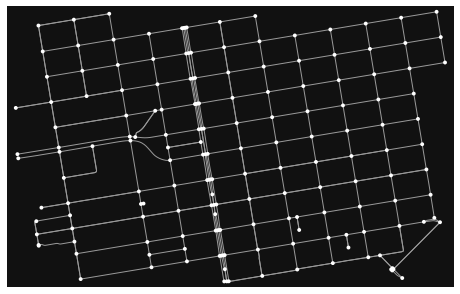

(<Figure size 576x576 with 1 Axes>, <AxesSubplot: >)

In [ ]:
G = ox.graph_from_bbox(37.79, 37.78, -122.41, -122.43, network_type='drive')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

#Constructing a Graph in networkx

In [ ]:
city_name="_Kolkata_"
location_point=(22.5726, 88.3639)   #coordinates
G=ox.graph_from_point(location_point,dist=2500,network_type="drive")
G_ = nx.relabel.convert_node_labels_to_integers(G)
G_proj = ox.project_graph(G_)
G_nx = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=False)
osmids = list(G_nx.nodes)
#G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)
# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G_nx.nodes, osmids)}
nx.set_node_attributes(G_nx, osmid_values, "osmid")

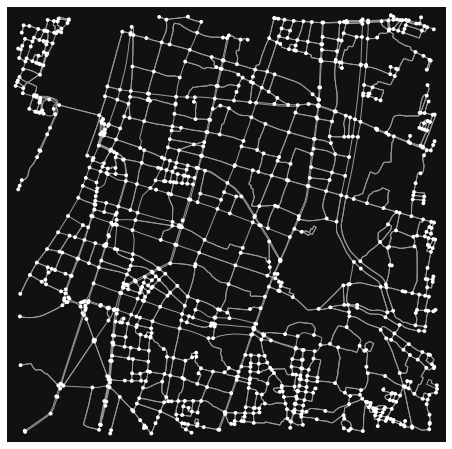

(<Figure size 576x576 with 1 Axes>, <AxesSubplot: >)

In [ ]:
ox.plot_graph(G_nx)

In [ ]:
#taking data
nodes=G_nx.number_of_nodes()
G_nx=nx.to_undirected(G_nx)
Edges=G_nx.number_of_edges()
planar_density=Edges/(3*nodes-6)
print(planar_density,nodes,Edges)
num_walkers=5000 #number of walkers
time=20000#number of steps taken

0.8492354740061162 1092 2777


##Computing adjacency list and a Dictionary containing degree of each node

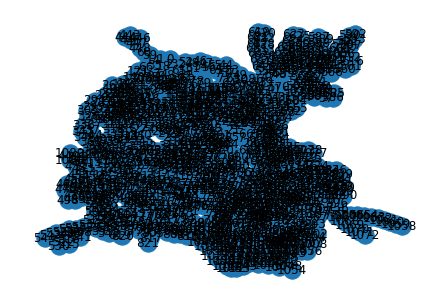

In [ ]:
nx.draw_kamada_kawai(G_nx,with_labels=True)

#Degree Distribution

##Original Graph(without consolidation)

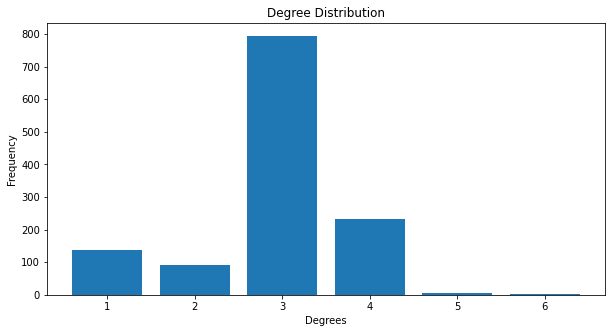

In [ ]:
nodes=G_.number_of_nodes()
adjacency_list_o,node_Degree_dict_o=adjacency_list_nodeDegree_osmnxG(G_,nodes)
Nodes_with_Degree=nodes_with_same_Degree(node_Degree_dict_o)
plotting_degree_distribution(Nodes_with_Degree)

##Consolidated Graph

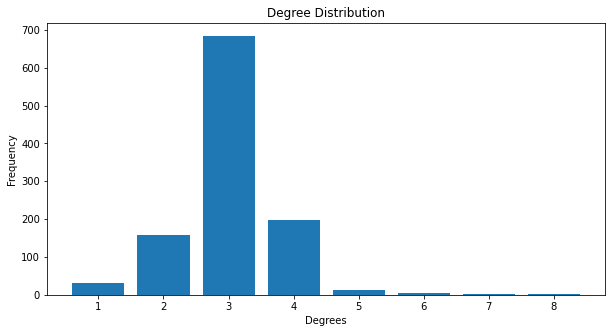

In [ ]:
nodes=G_nx.number_of_nodes()
adjacency_list,node_Degree_dict=adjacency_list_nodeDegree_osmnxG(G_nx,nodes)
Nodes_with_Degree=nodes_with_same_Degree(node_Degree_dict)
plotting_degree_distribution(Nodes_with_Degree)

In [ ]:
loops = [edge for edge in nx.selfloop_edges(G_nx)]
loops

In [ ]:
file_name="/content/drive/MyDrive/MS_thesis_work/adjacency_list"+city_name
storeData(adjacency_list,file_name)

In [ ]:
adjacency_list=loadData("/content/drive/MyDrive/MS_thesis_work/adjacency_list_NewYork_")
nodes_degree_dict={i:len(adjacency_list[i]) for i in adjacency_list}
nodes=len(list(adjacency_list.keys()))

In [ ]:
nodes_same_deg=nodes_with_same_Degree(nodes_degree_dict)

#Retrieving edge length

In [ ]:
length_dict=nx.get_edge_attributes(nx.to_undirected(G_nx),"length")

In [ ]:
file_name="SG_Edge_length"+city_name
storeData(length_dict,file_name)

In [ ]:
edge_length=[]

In [ ]:
length_dict1=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_Ahmedabad_")
length_dict2=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_NewYork_")
length_dict3=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_Delhi_")
length_dict4=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_Mumbai_")


In [ ]:
edge_length.append(list(length_dict4.values()))

#Distribution of edge length

mean road length= 88.70230325596154 standard deviation of road length= 95.33977615829086
minimum road length= 10.11 maximum road length= 1282.2159128081812


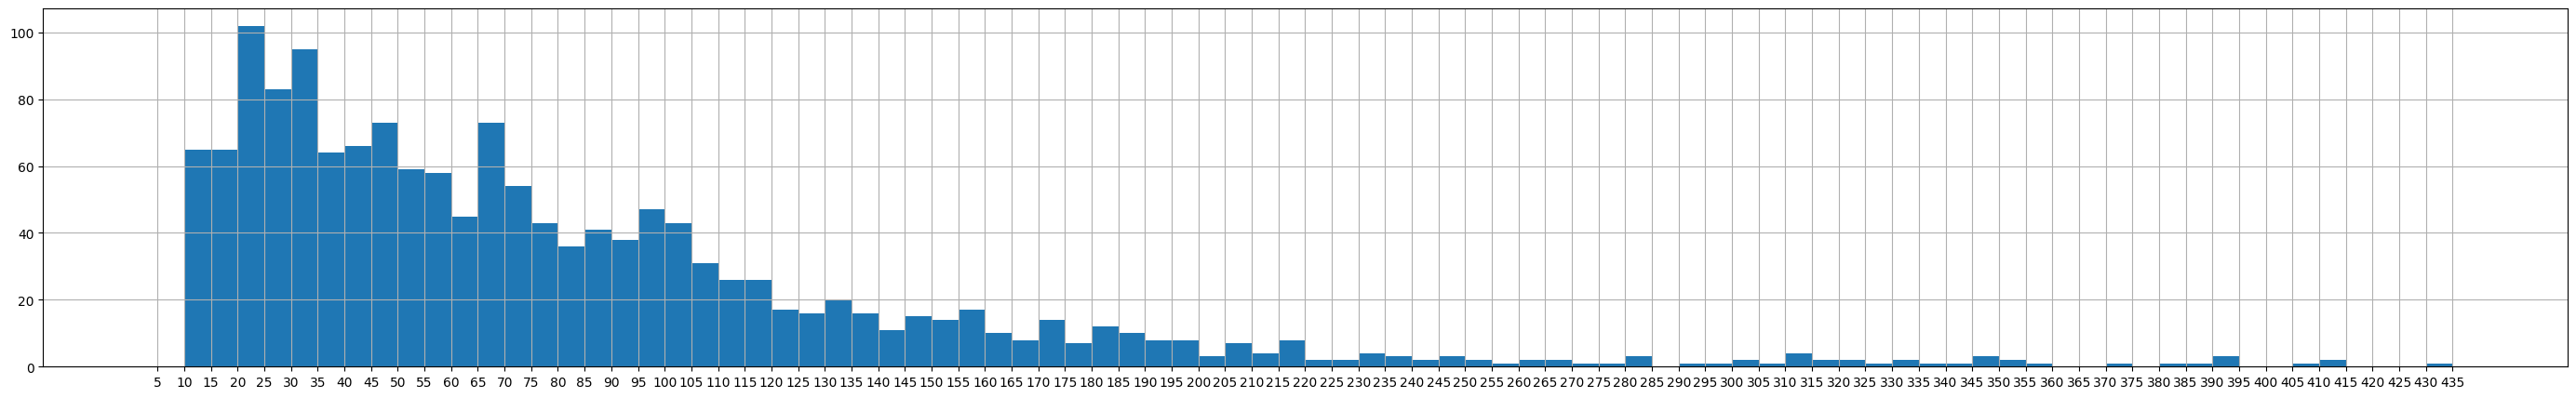

In [ ]:
dist=np.array([length_dict[i] for i in length_dict])
print("mean road length=",np.mean(dist),"standard deviation of road length=",np.std(dist))
min_len,max_len=np.min(dist),np.max(dist)
print("minimum road length=",min_len,"maximum road length=",max_len)
fig=plt.figure(figsize=(35,5))
bin=[i for i in range(5,440,5)]
plt.hist(dist,bins=bin)
plt.xticks(bin)
plt.grid()
#plt.xscale("log")
#nn,bins,patches=plt.hist(dist,bins=bin,rwidth=0.8,density=True)

In [ ]:
edges=3000
nodes=1000
num_walkers=5000
time=1000000
file_name="Degree_Biased_CTRW_Real_Network_of"+city_name+str(nodes)+"_nodes_"+str(edges)+"_Edges_"+str(num_walkers)+"_walkers_"+str(time)+"s"
file_name

'Degree_Biased_CTRW_Real_Network_of_Delhi_1000_nodes_3000_Edges_5000_walkers_1000000s'

In [ ]:
my_dict={1:2,2:3,4:5}
len(my_dict.keys())

3

#Waiting time distribution

In [ ]:
mu, sigma = 40,5 # mean and standard deviation
speed = np.random.normal(mu, sigma, 1000)*0.28

(array([ 1.,  0.,  1.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  2.,  5.,  1.,
         3.,  2.,  5.,  5.,  2.,  3.,  6.,  8.,  6., 10.,  7., 11.,  6.,
        12., 12., 13., 15., 13., 19., 17., 27., 27., 14., 21., 14., 16.,
        15., 19., 25., 18., 23., 22., 21., 34., 30., 25., 28., 27., 29.,
        21., 29., 27., 19., 23., 17., 14., 20., 20., 14., 10., 11., 16.,
        11., 13., 14.,  8., 10.,  7., 10.,  6.,  4.,  9.,  6.,  4.,  5.,
         6.,  2.,  3.,  1.,  1.,  3.,  2.,  1.,  3.,  1.,  1.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 7.08383896,  7.17082735,  7.25781574,  7.34480414,  7.43179253,
         7.51878092,  7.60576932,  7.69275771,  7.7797461 ,  7.86673449,
         7.95372289,  8.04071128,  8.12769967,  8.21468807,  8.30167646,
         8.38866485,  8.47565324,  8.56264164,  8.64963003,  8.73661842,
         8.82360681,  8.91059521,  8.9975836 ,  9.08457199,  9.17156039,
         9.25854878,  9.34553717,  9.43252556,  9.51951396,  9.606502

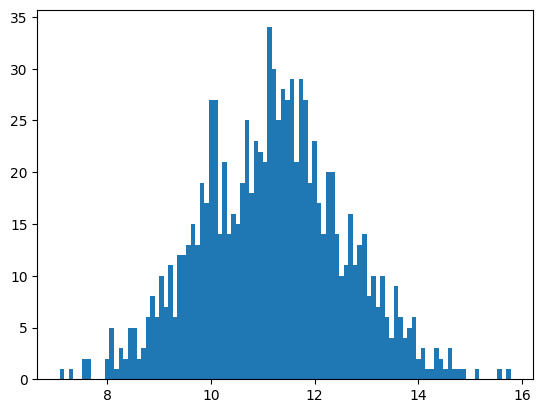

In [ ]:
plt.hist(speed,100)

In [ ]:
Time_interval=[]

In [ ]:
arrr=np.array(Time_interval[3])
np.mean(arrr),np.std(arrr),np.max(arrr),np.min(arrr)

(10.1952511840799, 9.416038891042582, 127.61441997771449, 0.6336060236374075)

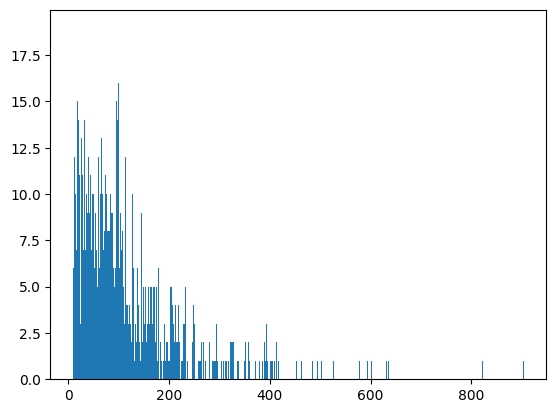

In [ ]:
length_dict=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_Mumbai_")  #Ahmedabad NewYork Delhi Mumbai
length= np.round_(np.array(list(length_dict.values())),0)
bins=np.arange(10,int(max(length))+2,1)
freq,bins,_=plt.hist(length,bins=bins,align="left")
lastElementIndex = len(bins)-1
# Removing the last element using slicing
new_bins = bins[:lastElementIndex]
freq_0_1=np.where(freq>0,1,0)
length_present=np.multiply(new_bins, freq_0_1)
length_present=length_present[length_present!=0]
non_zero_freq=np.where(freq>0,freq,0)
non_zero_freq=non_zero_freq[non_zero_freq!=0]
time_values=[]
for i,j in zip(length_present,non_zero_freq):
    time=list(i/speed)
    j=int(j)
    for k in range(j):
      time_values.extend(time)
Time_interval.append(time_values)

In [ ]:
xlabel=r"$T_{edges}$"
plt.xlabe(xlabel)

'$T_{edges}$'

In [ ]:
Time_interval=loadData("/content/drive/MyDrive/MS_thesis_work/TimeInterval_values")

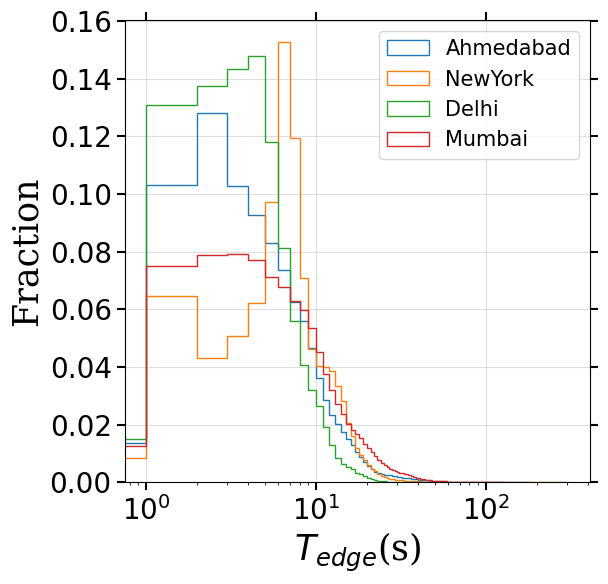

In [ ]:
font = {'family': 'serif',
         'color':  'black',
        'weight': 'normal',
        'size': 25}
xlabel="Edge Time Travel Interval(s)"
xlabel=r"$T_{edge}$(s)"
ylabel="Fraction"
fig=plt.figure(figsize=(6,6))
ax = fig.gca()
for i,city in zip(range(0,4),["Ahmedabad","NewYork","Delhi","Mumbai"]):
   arr=Time_interval[i]
   bins=np.arange(0,np.max(arr)+1,1)
   plt.hist(arr,bins=bins, density=True,histtype='step',align="mid",cumulative=0,label=city)

#plt.hist(bw_c,bins=100, density=True,histtype='step',cumulative=1)
plt.xlabel(xlabel,font)
plt.grid(alpha=0.4)
plt.legend(fontsize=15)
plt.ylabel(ylabel,font)
plt.xscale("log")
#plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(bottom=True, top=True, left=True, right=True ,length=6, width=1.5)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, length=6, width=1.5)
#ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
#fig.tight_layout()
plt.show()

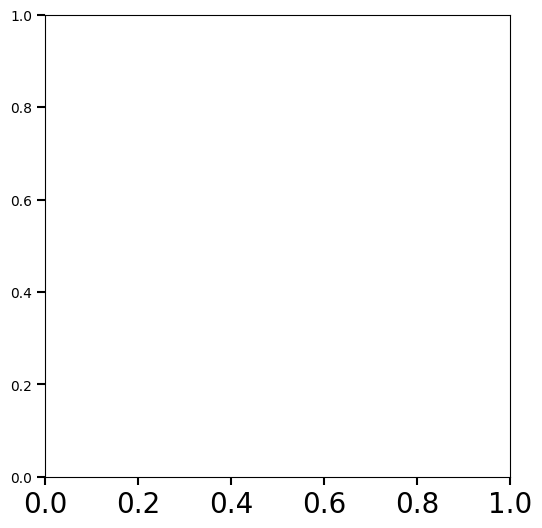

In [ ]:
import matplotlib as mpl
fig=plt.figure(figsize=(6,6))
ax = fig.gca()
ax.tick_params(axis='both',which='both',direction='out', length=6, width=1.5, colors='k',
               grid_color='r', grid_alpha=1,zorder=2,grid_linewidth=55)
plt.xticks(fontsize=20)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, length=6, width=1.5)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rc('axes', labelsize=20, titlesize=20)

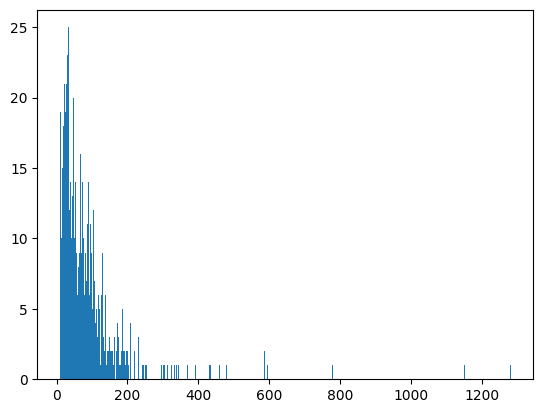

In [ ]:
length_dict=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_Ahmedabad_")  #Ahmedabad NewYork Delhi Mumbai
length= np.round_(np.array(list(length_dict.values())),0)
bins=np.arange(10,int(max(length))+2,1)
freq,bins,_=plt.hist(length,bins=bins,align="left")
lastElementIndex = len(bins)-1
# Removing the last element using slicing
new_bins = bins[:lastElementIndex]

In [ ]:
freq_0_1=np.where(freq>0,1,0)
length_present=np.multiply(new_bins, freq_0_1)
length_present=length_present[length_present!=0]
length_present

array([  10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,
         19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,  129.,  130.,  131.,  132.,  133.,  134.,  135.,
        136.,  137.,

In [ ]:
non_zero_freq=np.where(freq>0,freq,0)
non_zero_freq=non_zero_freq[non_zero_freq!=0]

In [ ]:
time_values=[]
for i,j in zip(length_present,non_zero_freq):
    time=list(i/speed)
    j=int(j)
    for k in range(j):
      time_values.extend(time)


In [ ]:
length_dict=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_Ahmedabad_")  #Ahmedabad NewYork Delhi Mumbai
length= length_dict.values()
time_value= {i:i/speed for i in length}
#time_values=np.array(list(time_value.values())
values=list(time_value.values())
Time_interval.append(values)

In [ ]:
storeData(Time_interval,"/content/drive/MyDrive/MS_thesis_work/TimeInterval_values")

mean time= 8.154058651948032 standard deviation= 8.89074445819461
minimum time= 0.7481410791392095 maximum time= 176.2104580445566


Text(0, 0.5, 'Freqency')

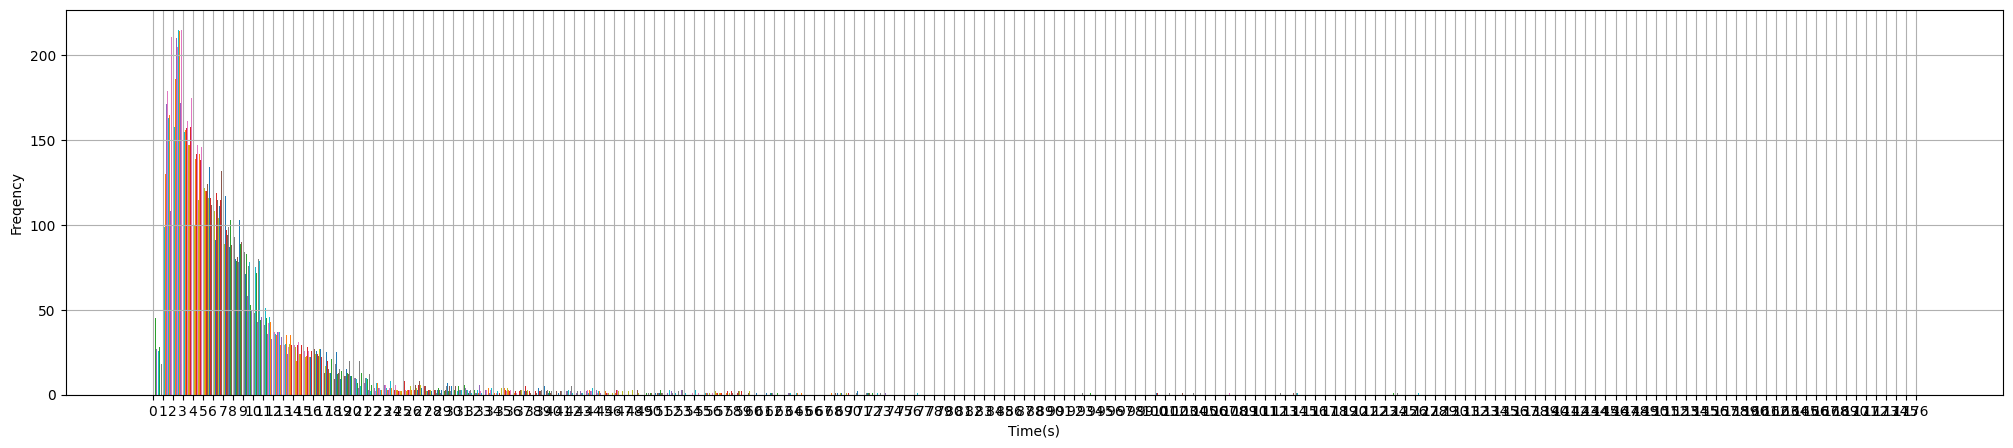

In [ ]:
length_dict=loadData("/content/drive/MyDrive/MS_thesis_work/Edge_length_Ahmedabad_")
length= length_dict.values()
time_value= {i:i/speed for i in length}
time_values=np.array(list(time_value.values()))
print("mean time=",np.mean(time_values),"standard deviation=",np.std(time_values))
min_len,max_len=np.min(time_values),np.max(time_values)
print("minimum time=",min_len,"maximum time=",max_len)
fig=plt.figure(figsize=(25,5))
bin=[i for i in range(int(min_len),int(max_len)+1,1)]
plt.hist(time_values,bins=bin)
plt.xticks(bin)
plt.grid()
plt.xlabel("Time(s)")
plt.ylabel("Freqency")
#nn,bins,patches=plt.hist(dist,bins=bin,rwidth=0.8,density=True)

mean time= 8.043637902518755 standard deviation= 8.628119856840824
minimum time= 0.7650234533143617 maximum time= 122.88666644787875


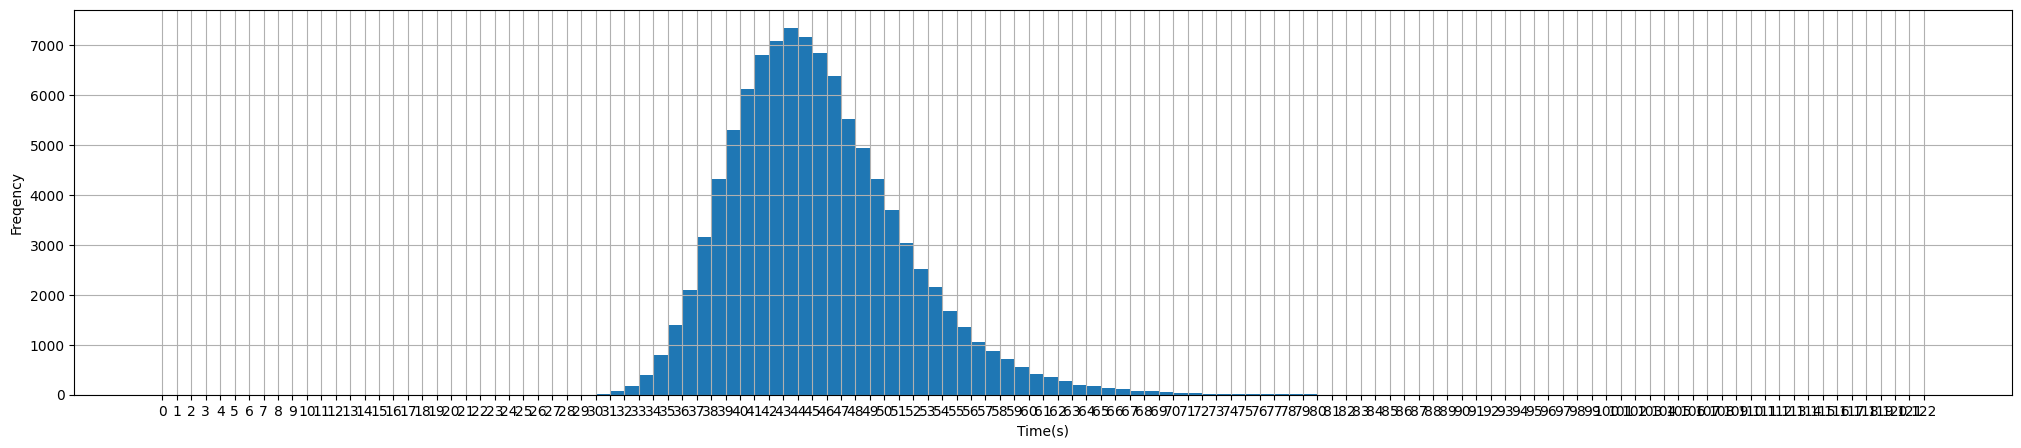

In [ ]:
mu, sigma = 40,5 # mean and standard deviation
s = np.random.normal(mu, sigma, len(dist))*0.28
time_values=dist/s
print("mean time=",np.mean(time_values),"standard deviation=",np.std(time_values))
min_len,max_len=np.min(time_values),np.max(time_values)
print("minimum time=",min_len,"maximum time=",max_len)
fig=plt.figure(figsize=(25,5))
bin=[i for i in range(int(min_len),int(max_len)+1,1)]
plt.hist(time_values,bins=bin)
plt.xticks(bin)
plt.grid()
plt.xlabel("Time(s)")
plt.ylabel("Freqency")
nn,bins,patches=plt.hist(dist,bins=bin,rwidth=0.8,density=True)

(array([0.01134689, 0.        , 0.        , 0.01134689, 0.01134689,
        0.01134689, 0.01134689, 0.01134689, 0.        , 0.01134689,
        0.02269379, 0.01134689, 0.03404068, 0.02269379, 0.        ,
        0.03404068, 0.01134689, 0.        , 0.03404068, 0.05673446,
        0.09077514, 0.05673446, 0.07942825, 0.09077514, 0.05673446,
        0.10212204, 0.06808136, 0.11346893, 0.10212204, 0.1588565 ,
        0.13616271, 0.17020339, 0.1588565 , 0.20424407, 0.07942825,
        0.19289718, 0.27232543, 0.317713  , 0.17020339, 0.23828475,
        0.24963164, 0.30636611, 0.19289718, 0.28367232, 0.30636611,
        0.28367232, 0.317713  , 0.18155029, 0.28367232, 0.23828475,
        0.30636611, 0.29501922, 0.317713  , 0.32905989, 0.30636611,
        0.24963164, 0.18155029, 0.18155029, 0.29501922, 0.20424407,
        0.27232543, 0.26097854, 0.27232543, 0.17020339, 0.19289718,
        0.13616271, 0.14750961, 0.1588565 , 0.17020339, 0.14750961,
        0.11346893, 0.05673446, 0.06808136, 0.11

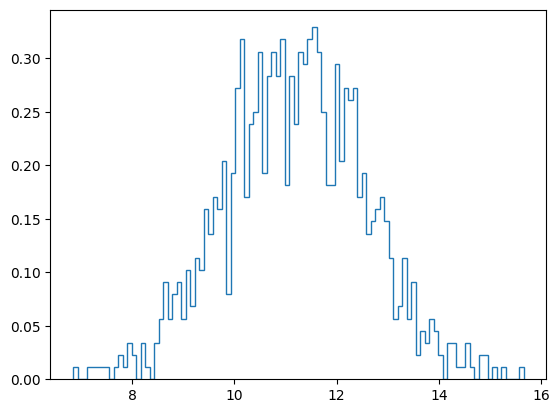

In [ ]:
mu, sigma = 40,5 # mean and standard deviation
s = np.random.normal(mu, sigma,1000)*0.28
plt.hist(s,bins=100,density=True,histtype='step',align="mid",cumulative=0)

In [ ]:
18/5

3.6

In [ ]:
s

array([11.38500256, 11.87821506,  9.80016235, ..., 11.98874932,
       11.64879289, 13.14966442])

In [ ]:
mu, sigma = 40,5 # mean and standard deviation
speed = np.random.normal(mu, sigma, 100000)*0.28
for i in range(4):
  time_values=np.arrayedge_length[i]/s
  print("mean time=",np.mean(time_values),"standard deviation=",np.std(time_values))

In [ ]:
node_Degree_dict={i:len(adjacency_list[i]) for i in adjacency_list}
Nodes_with_Degree=nodes_with_same_Degree(node_Degree_dict)

#Creating Time Series

In [ ]:
Time_S=CTRW_sim(nodes,length_dict,adjacency_list,node_Degree_dict,num_walkers,time)

In [ ]:
wal_on_each_node=Walk_each_node(nodes,Time_S)

In [ ]:
time_series_each_node=Time_series_each_node(nodes,wal_on_each_node)

In [ ]:
time_series_each_node[0]

In [ ]:
s=time_series_each_node[470]
G_nx.degree(470)

2

In [ ]:
s.keys()

odict_keys([0, 23.5, 70.9, 94.3, 151.0, 202.9, 219.4, 235.0, 268.9, 402.5, 407.4, 416.8, 452.8, 464.4, 481.1, 496.0, 497.6, 500.4, 503.7, 505.8, 508.4, 512.0, 702.6, 707.9, 712.6, 716.7, 748.8, 749.5, 775.1, 781.5, 785.2, 908.3, 913.3, 965.1, 1109.2, 1179.8, 1241.0, 1340.6, 1355.6, 1365.9, 1395.0, 1398.8, 1401.1, 1452.2, 1540.0, 1566.6, 1575.8, 1632.8, 1674.8, 1696.5, 1735.7, 1769.9, 1866.8, 1895.0, 1956.2, 1968.9, 1973.8])

In [ ]:
ss=[]
for i in range(nodes):
  t=time_series_each_node[i]
  l=list(t.keys())
  if l==[]:
    print(i)
  ss.append(l[-1])

In [ ]:
nodes=1092

In [ ]:
time_series_each_node=loadData("/content/drive/MyDrive/MS_thesis_work/DB_CTRW/DB_CTRW_2_NewYork_5000_walkers_11000s")

In [ ]:
time_series_each_node[0]

OrderedDict([(0, 6),
             (1.8, 1),
             (2.2, 1),
             (5.3, 1),
             (5.5, 1),
             (9.5, 1),
             (10.8, 1),
             (12.3, 1),
             (18.8, 1),
             (19.3, 1),
             (19.6, 1),
             (20.8, 1),
             (21.0, 2),
             (22.4, 1),
             (23.9, 1),
             (25.2, 1),
             (26.8, 1),
             (27.5, 1),
             (29.7, 1),
             (34.8, 1),
             (38.4, 1),
             (41.5, 1),
             (41.6, 1),
             (41.7, 1),
             (53.7, 1),
             (59.6, 1),
             (65.6, 1),
             (68.4, 1),
             (69.1, 1),
             (71.8, 1),
             (74.1, 1),
             (75.3, 1),
             (75.6, 1),
             (79.3, 1),
             (82.9, 1),
             (83.3, 1),
             (88.6, 1),
             (103.7, 1),
             (105.0, 1),
             (111.9, 1),
             (116.0, 1),
             (117.6,

In [ ]:
print(comp_mini_ended_valueforTimeSeries(nodes,time_series_each_node))

9922.7


In [ ]:
Time_series_CTRW_node_dict=Time_series_CTRW_windowtime(10,10000,Time_S,nodes)

36 36


IndexError: ignored

In [ ]:
Time_series_CTRW_node_dict[5]

[[0, 5.0],
 [10, 3.0],
 [20, 5.0],
 [30, 7.0],
 [40, 7.0],
 [50, 2.0],
 [60, 5.0],
 [70, 9.0],
 [80, 3.0],
 [90, 6.0],
 [100, 5.0],
 [110, 3.0],
 [120, 6.0],
 [130, 3.0],
 [140, 2.0],
 [150, 6.0],
 [160, 3.0],
 [170, 4.0],
 [180, 4.0],
 [190, 5.0],
 [200, 4.0],
 [210, 4.0],
 [220, 4.0],
 [230, 7.0],
 [240, 4.0],
 [250, 2.0],
 [260, 4.0],
 [270, 5.0],
 [280, 6.0],
 [290, 5.0],
 [300, 5.0],
 [310, 3.0],
 [320, 7.0],
 [330, 2.0],
 [340, 2.0],
 [350, 5.0],
 [360, 5.0],
 [370, 0],
 [380, 3.0],
 [390, 0],
 [400, 2.0],
 [410, 0],
 [420, 2.0],
 [430, 3.0],
 [440, 2.0],
 [450, 3.0],
 [460, 3.0],
 [470, 1.0],
 [480, 5.0],
 [490, 5.0],
 [500, 4.0],
 [510, 7.0],
 [520, 4.0],
 [530, 7.0],
 [540, 1.0],
 [550, 3.0],
 [560, 4.0],
 [570, 1.0],
 [580, 8.0],
 [590, 3.0],
 [600, 6.0],
 [610, 6.0],
 [620, 6.0],
 [630, 3.0],
 [640, 10.0],
 [650, 4.0],
 [660, 4.0],
 [670, 1.0],
 [680, 4.0],
 [690, 3.0],
 [700, 2.0],
 [710, 5.0],
 [720, 2.0],
 [730, 3.0],
 [740, 4.0],
 [750, 5.0],
 [760, 4.0],
 [770, 4.0],
 [

##Saving time series in a file

#Computing average and standard deviation of walkers for each node

In [ ]:
dic_mean_walkers ,dic_std_walkers=mean_std_walkers_nodewise(Time_series_CTRW_node_dict,nodes)

##Distribution of Average numbers of walkers computed for all nodes

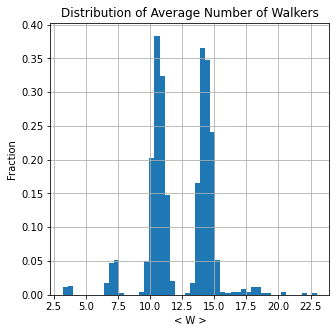

In [ ]:
mean_walkers =np.array([dic_mean_walkers[i] for i in dic_mean_walkers])
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=50
fsize=(5,5)
xlabel,ylabel,title="< W >","Fraction","Distribution of Average Number of Walkers"
HistoGram(mean_walkers ,bins,True,1,xlabel,ylabel,'mid',title,fsize)

##Distribution of Standard deviation of numbers of walkers computed for all nodes

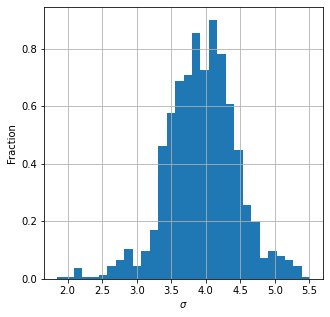

In [ ]:
std_walkers =np.array([dic_std_walkers[i] for i in dic_std_walkers])
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=30
fsize=(5,5)
xlabel,ylabel,title=r"$\sigma$","Fraction",""
HistoGram(std_walkers,bins,True,1,xlabel,ylabel,'mid',title,fsize)

##Computing average and standard deviation of walkers degreewise

In [ ]:
Average_walk_degreewise,Std_walk_degreewise=walkers_statistic_degreewise(nodes_same_deg,dic_mean_walkers,dic_std_walkers)

##Distribution of Average numbers of walkers (Computed degreewise)
Here, I am plotting the distribution of numbers of walkers average over degree of nodes

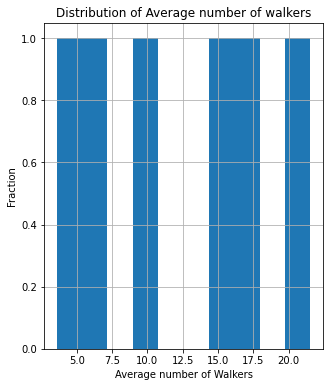

In [ ]:
Avg_walkers =np.array(Average_walk_degreewise)
Avg_walkers_only=Avg_walkers[::,1]
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=10
fsize=(5,6)
xlabel,ylabel,title="Average number of Walkers","Fraction","Distribution of Average number of walkers"
HistoGram(Avg_walkers_only,bins,False,1,xlabel,ylabel,'mid',title,fsize)

In [ ]:
Avg_walkers_only

array([ 3.58580821,  7.11843034, 10.67020825, 14.36851999, 17.79857175,
       21.53927681])

##**Variation of average number of walkers with degree of nodes**

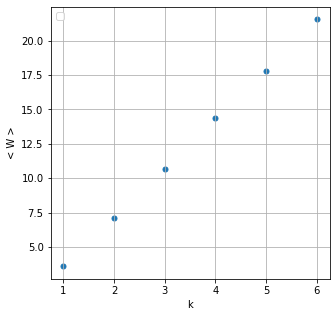

In [ ]:
xarr,yarr=Avg_walkers[::,0],Avg_walkers[::,1]
fig=plt.figure(figsize=(5,5))
xlabel="k"
ylabel="< W >"
title=""
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=25,opacity=1,marker="o")

In [ ]:
Average_walkers_same_degree=[]
Std_walkers_same_degree=[]
labels=[]
for i in nodes_same_deg:
  x=[dic_mean_walkers[node] for node in i[1]]
  Average_walkers_same_degree.append(x)
  y=[dic_std_walkers[node] for node in i[1]]
  Std_walkers_same_degree.append(y)
  labels.append(str(i[0]))

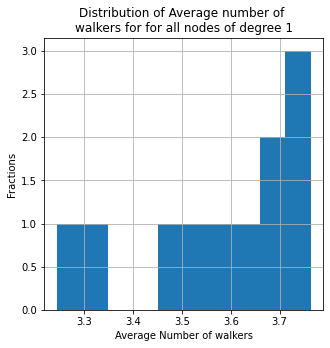

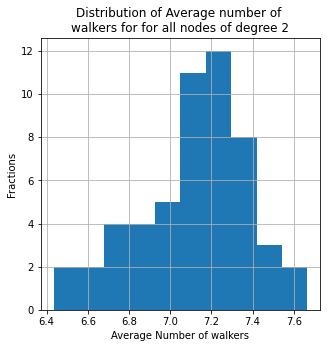

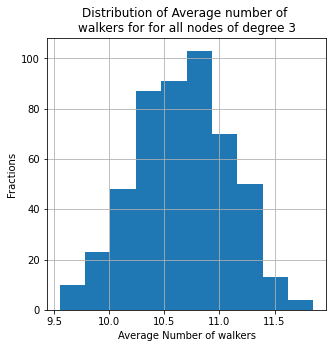

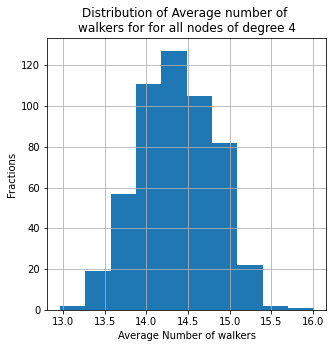

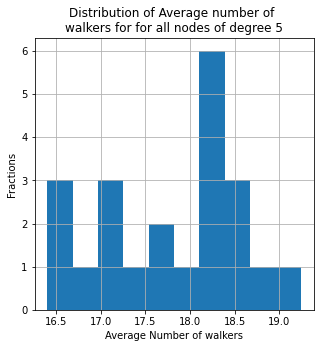

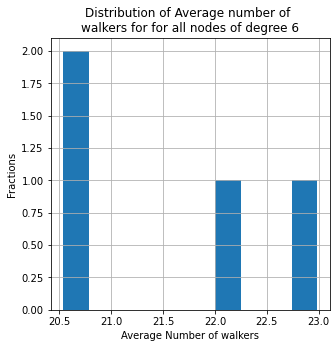

In [ ]:
xlabel,ylabel,title="Average Number of walkers","Fractions","Distribution of Average number of \nwalkers for for all nodes of degree "
for i,j in enumerate(Average_walkers_same_degree):
  bins=10
  HistoGram(j,bins,False,1,xlabel,ylabel,'mid',title+str(i+1),(5,5))

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


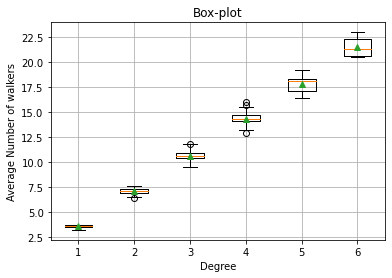

In [ ]:
xlabel,ylabel,title="Degree","Average Number of walkers","Box-plot"
xarr=Average_walkers_same_degree
Box_Plot(xarr,xlabel,ylabel,title,labels)

##Distribution of standard deviation of numbers of walkers(computed degreewise)
Here, I am plotting the distribution of numbers of walkers average over degree of nodes.

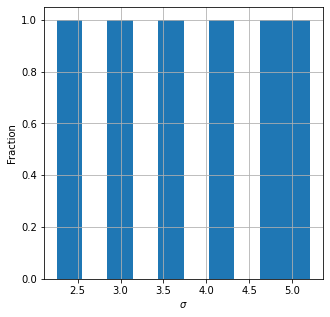

In [ ]:
Std_walkers =np.array(Std_walk_degreewise)
Std_walkers_only=Std_walkers[::,1]
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=10
fsize=(5,5)
xlabel,ylabel,title=r"$\sigma$","Fraction",""
HistoGram(Std_walkers_only,bins,False,1,xlabel,ylabel,'mid',title,fsize)

In [ ]:
Std_walkers_only

array([2.25760822, 3.02301921, 3.70010738, 4.2722211 , 4.69599441,
       5.21085487])

##**Variation of Std of number of walkers with degree of nodes**

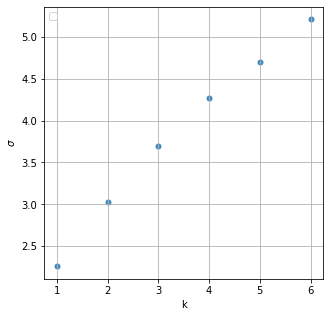

In [ ]:
xarr,yarr=Std_walkers[::,0],Std_walkers[::,1]
fig=plt.figure(figsize=(5,5))
xlabel="k"
ylabel=r"$\sigma$"
title=""
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=25,opacity=0.8,marker="o")

##**Variation of Average number of walkers with standard deviation**

scaling= 0.806920940169682 exponent= 0.568132309141157 shifting= 0.584808440025895


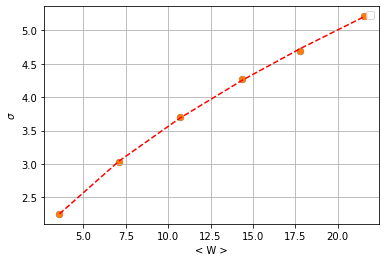

In [ ]:
xarr=Avg_walkers_only
yarr=Std_walkers_only
xlabel,ylabel,title="< W >",r"$\sigma$",""
labels="Variation"
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=40,opacity=0.8,marker="o")
curve_fitting(xarr,yarr)

#Variation of $\sigma$ with $<w>$ computed for all nodes

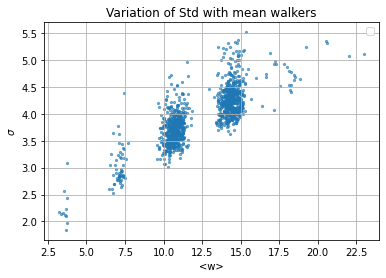

In [ ]:
xarr,yarr=np.array([dic_mean_walkers[i] for i in dic_mean_walkers]),np.array([dic_std_walkers[i] for i in dic_std_walkers])
xlabel,ylabel,title="<w>",r'$ \sigma $',"Variation of Std with mean walkers"
scatter_Plot(xarr,yarr,xlabel,ylabel,title,dotsize=5,opacity=0.6,marker=".")

#Extreme Event Probablity Computation and plotting

In [ ]:
Scaling_factor=4
threshold_dict,EEP_nodewise,EEP_degreewise=ExtremeEventProb(nodes,nodes_same_deg,Scaling_factor,Time_series_CTRW_node_dict,dic_mean_walkers,dic_std_walkers)

##Distribution of threshold values computed for all nodes

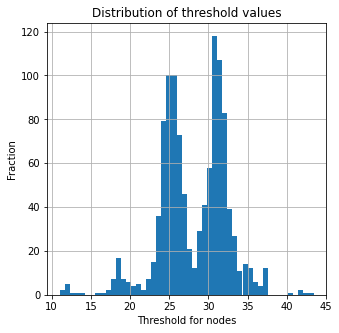

In [ ]:
threshold_values=np.array([threshold_dict[i] for i in threshold_dict])
bins=50
fsize=(5,5)
xlabel,ylabel,title="Threshold for nodes","Fraction","Distribution of threshold values"
HistoGram(threshold_values,bins,False,1,xlabel,ylabel,'mid',title,fsize)

##Distribution of Probability of Extreme event values(computed for all nodes)

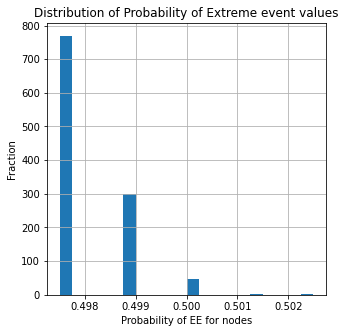

In [ ]:
ExtremeEventN_values=np.array([EEP_nodewise[i] for i in EEP_nodewise])
bins=20
xlabel,ylabel,title="Probability of EE for nodes","Fraction","Distribution of Probability of Extreme event values"
HistoGram(ExtremeEventN_values,bins,False,1,xlabel,ylabel,'mid',title,fsize)

##Distribution of Probability of Extreme event values average over nodes of same degree

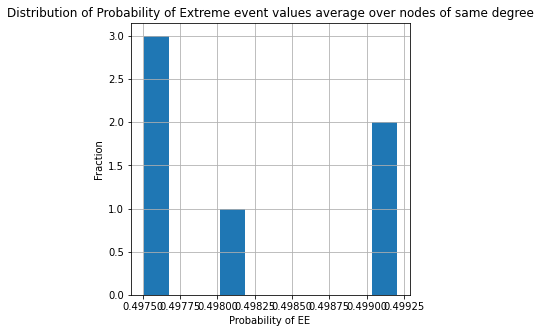

In [ ]:
ExtremeEventD_values=np.array([EEP_degreewise[i] for i in EEP_degreewise])
bins=10
xlabel,ylabel,title="Probability of EE ","Fraction","Distribution of Probability of Extreme event values average over nodes of same degree"
HistoGram(ExtremeEventD_values,bins,False,1,xlabel,ylabel,'mid',title,fsize)

In [ ]:
ExtremeEventD_values

array([0.49920653, 0.49915306, 0.4981784 , 0.49761486, 0.49761959,
       0.49750623])

##Variation of Probability of Occurrence of extreme event with degree of nodes

Text(0.5, 0, 'Degrees')

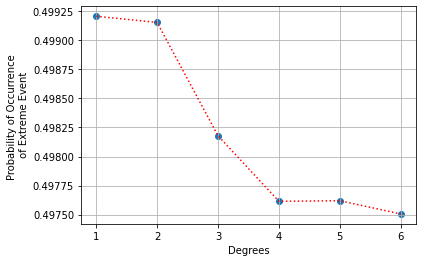

In [ ]:
extreme_eventP_degreewise=np.array([[j,EEP_degreewise[j]] for j in EEP_degreewise])
xarr,yarr=extreme_eventP_degreewise[::,0],extreme_eventP_degreewise[::,1]
plt.scatter(extreme_eventP_degreewise[::,0],extreme_eventP_degreewise[::,1])
plt.plot(extreme_eventP_degreewise[::,0],extreme_eventP_degreewise[::,1],color='r',ls=':')
plt.ylabel("Probability of Occurrence \n of Extreme Event")
plt.grid()
plt.xlabel("Degrees")

##Variation of Extreme event probability curve with Window Time

In [ ]:
import matplotlib.image as mpimg

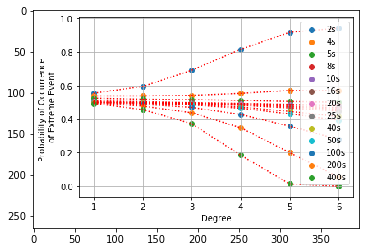

In [ ]:
img = mpimg.imread('Degreewise_CTRW_EE_alpha_2.png')
imgplot = plt.imshow(img)

In [ ]:
for i in [2,4,5,8,10,16,20,25,40,50,100,200,300,400,500,600]:
  Time_series_CTRW_node_dict_=Time_series_CTRW_windowtime(i,9600,time_series_each_node,nodes)
  dic_mean_walkers_ ,dic_std_walkers_=mean_std_walkers_nodewise(Time_series_CTRW_node_dict_,nodes)
  Scaling_factor=2
  threshold,EEP_nodewise,EEP_degreewise=ExtremeEventProb(nodes,Nodes_with_Degree,Scaling_factor,Time_series_CTRW_node_dict,dic_mean_walkers_,dic_std_walkers_)
  extreme_eventP_degreewise=np.array([[j,EEP_degreewise[j]] for j in EEP_degreewise])
  xarr,yarr=extreme_eventP_degreewise[::,0],extreme_eventP_degreewise[::,1]
  plt.scatter(xarr,yarr,label=str(i)+"s")
  plt.plot(xarr,yarr,color='r',ls=':')
plt.ylabel("Probability of Occurrence \n of Extreme Event")
plt.grid()
plt.xlabel("Degree")
plt.legend()

In [ ]:
np.random.binomial(10, 0.8,1000)

7

#Computing Recurrence Time Interval

In [ ]:
recurrence_Time_each_node=Extreme_Event_recurrenceTime_eachnode(nodes,Time_series_CTRW_node_dict,threshold_dict)

ValueError: ignored

##Distribution of recurrence time interval for a node

In [ ]:
node=59
recrrenceTimeNode=np.array(recurrence_Time_each_node[node])
#bins=np.array([i for i in range(int(np.min(walkers_arr)),int(np.max(walkers_arr))+2,1)])
bins=20
fsize=(12,8)
xlabel,ylabel,title="Recurrence Time","Fraction","Distribution of Recurrence time for a node "+str(node)
HistoGram(recrrenceTimeNode ,bins,True,1,xlabel,ylabel,'mid',title,fsize)

NameError: ignored

##Computing average recurrence time for each node and also degreewise

In [ ]:
average_recurrenceT_nodewise,average_recurrenceT_degreewise=Average_recurrenceTime__Node_Degreewise(nodes,Nodes_with_Degree,recurrence_Time_each_node)

##Distribution of Recurrence Time Interval computed for all nodes

In [ ]:
RecurrenecTime_values_all_nodes=[average_recurrenceT_nodewise[i] for i in average_recurrenceT_nodewise]
bins=20
fsize=(12,8)
xlabel,ylabel,title="Recurrence Time(s)","Fraction","Distribution of Recurrence time computed for all nodes"
HistoGram(RecurrenecTime_values_all_nodes ,bins,True,1,xlabel,ylabel,'mid',title,fsize)

In [ ]:
np.append([[1, 2, 3], [4, 5, 6]], [[7, 8, 9]], axis=0)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [ ]:
import numpy as np
a=np.array([3,5])
b=np.array([38,7])
a=np.append([a],[b],axis=0)
a

array([[ 3,  5],
       [38,  7]])